In [17]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

 98% 1.05G/1.06G [00:15<00:00, 36.6MB/s]
100% 1.06G/1.06G [00:15<00:00, 75.7MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [23]:
import pandas as pd
import numpy as np
from keras.models import Sequential
import tensorflow
from keras.layers import Dense,Flatten,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
num_classes=2
img_rows,img_cols=128,128
batch_size=8

train_dir='/content/dogs_vs_cats/train'
valid_dir='/content/dogs_vs_cats/test'

train_data_gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')


valid_data_gen=ImageDataGenerator(
    rescale=1./255
)

train_generator=train_data_gen.flow_from_directory(
    train_dir,
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
)

validation_generator=valid_data_gen.flow_from_directory(
    valid_dir,
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_rows, img_cols, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))




model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))


print(model.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_15 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 62, 62, 64)        18496     
                                                                 
 batch_normalization_16 (Ba  (None, 62, 62, 64)        256       
 tchNormalization)                                               
                                                      

In [26]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint=ModelCheckpoint('dogscats.h5',
                          monitor="val_loss",
                          mode="min",
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

reduce_lr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.001,
    patience=3,
    verbose=1,
    min_delta=0.0001

)

callbacks=[earlystop,checkpoint,reduce_lr]
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

num_train_samples=20000
num_valid_samples=5000
epochs=15

history=model.fit_generator(
train_generator,
    steps_per_epoch=num_train_samples//batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=num_valid_samples//batch_size
)

Epoch 1/15


<ipython-input-26-43de388cf6fa>:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(


2500/2500 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.5671
Epoch 1: val_loss improved from inf to 0.68636, saving model to dogscats.h5
2500/2500 [==============================] - 896s 358ms/step - loss: 0.6971 - accuracy: 0.5671 - val_loss: 0.6864 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 2/15
2500/2500 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.5781
Epoch 2: val_loss did not improve from 0.68636
2500/2500 [==============================] - 896s 358ms/step - loss: 0.6802 - accuracy: 0.5781 - val_loss: 0.7546 - val_accuracy: 0.6118 - lr: 0.0010
Epoch 3/15
2500/2500 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.6010
Epoch 3: val_loss improved from 0.68636 to 0.62551, saving model to dogscats.h5
2500/2500 [==============================] - 926s 370ms/step - loss: 0.6709 - accuracy: 0.6010 - val_loss: 0.6255 - val_accuracy: 0.6482 - lr: 0.0010
Epoch 4/15
2500/2500 [==============================] - ETA: 0s 

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming 'classifier' is your trained model
target_names = ['Cat', 'Dog']

# Confusion Matrix and Classification Report
Y_pred = classifier.predict_generator(validation_generator, num_valid_samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))



<ipython-input-39-f11c1a048b0a>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = classifier.predict_generator(validation_generator, num_valid_samples // batch_size + 1)


Confusion Matrix
[[1319 1181]
 [1339 1161]]
Classification Report
              precision    recall  f1-score   support

         Cat       0.50      0.53      0.51      2500
         Dog       0.50      0.46      0.48      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



1/1 [==============================] - 0s 140ms/step


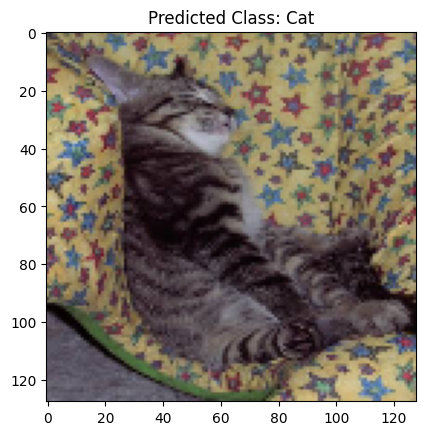

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Define the class labels
class_labels = {0: 'Cat', 1: 'Dog'}

# Load the pre-trained model
classifier = load_model('/content/dogscats.h5')

# Load and preprocess the test image
test_image_path = '/content/test/cats/cat.10026.jpg'
test_image = image.load_img(test_image_path, target_size=(128, 128, 3))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)

# Normalize the pixel values to be in the range [0, 1]
test_image_array /= 255.0

# Make predictions
result = classifier.predict(test_image_array)

# Get the predicted class index
predicted_class_index = np.argmax(result)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Display the image
plt.imshow(test_image)
plt.title(f"Predicted Class: {predicted_class_label}")
plt.show()


1/1 [==============================] - 0s 141ms/step


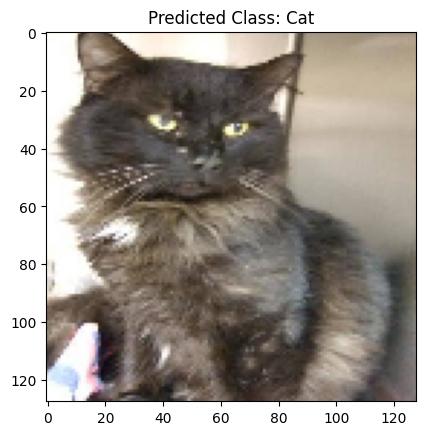

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Define the class labels
class_labels = {0: 'Cat', 1: 'Dog'}

# Load the pre-trained model
classifier = load_model('/content/dogscats.h5')

# Load and preprocess the test image
test_image_path = '/content/test/cats/cat.10415.jpg'
test_image = image.load_img(test_image_path, target_size=(128, 128, 3))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)

# Normalize the pixel values to be in the range [0, 1]
test_image_array /= 255.0

# Make predictions
result = classifier.predict(test_image_array)

# Get the predicted class index
predicted_class_index = np.argmax(result)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Display the image
plt.imshow(test_image)
plt.title(f"Predicted Class: {predicted_class_label}")
plt.show()


1/1 [==============================] - 0s 151ms/step


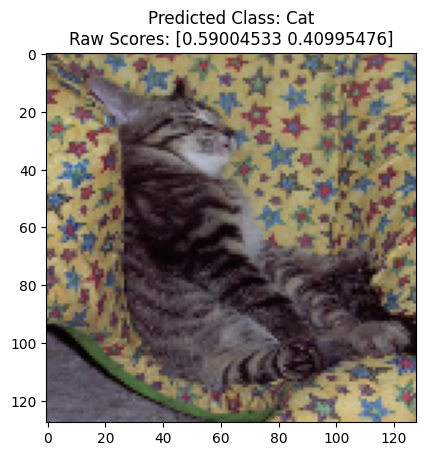

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Define the class labels
class_labels = {0: 'Cat', 1: 'Dog'}

# Load the pre-trained model
classifier = load_model('/content/dogscats.h5')

# Load and preprocess the test image
test_image_path = '/content/test/cats/cat.10026.jpg'
test_image = image.load_img(test_image_path, target_size=(128, 128, 3))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)

# Normalize the pixel values to be in the range [0, 1]
test_image_array /= 255.0

# Make predictions
result = classifier.predict(test_image_array)

# Get the predicted class index
predicted_class_index = np.argmax(result)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Display the image
plt.imshow(test_image)
plt.title(f"Predicted Class: {predicted_class_label}\nRaw Scores: {result[0]}")
plt.show()


1/1 [==============================] - 0s 219ms/step


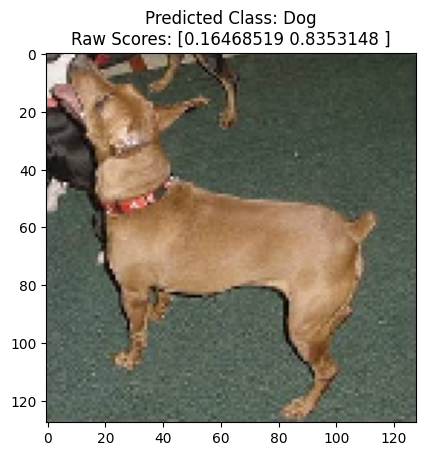

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Define the class labels
class_labels = {0: 'Cat', 1: 'Dog'}

# Load the pre-trained model
classifier = load_model('/content/dogscats.h5')

# Load and preprocess the test image
test_image_path = '/content/test/dogs/dog.10010.jpg'
test_image = image.load_img(test_image_path, target_size=(128, 128, 3))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)

# Normalize the pixel values to be in the range [0, 1]
test_image_array /= 255.0

# Make predictions
result = classifier.predict(test_image_array)

# Get the predicted class index
predicted_class_index = np.argmax(result)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Display the image
plt.imshow(test_image)
plt.title(f"Predicted Class: {predicted_class_label}\nRaw Scores: {result[0]}")
plt.show()


SyntaxError: ignored